<a href="https://colab.research.google.com/github/victoriavo256/cs123b-final-proj/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

# Utils
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance



drive.mount('/content/drive')

PATH = "/content/drive/Shareddrives/123B Project/279_cases/"

Mounted at /content/drive


# Data

In [ ]:
# Read in data
df = pd.read_csv(PATH + "csv/knn_imputed.csv")

# Print df to see what columns to drop
pd.set_option('display.max_columns', None)

# Manually drop columns
cols_to_drop = [
    'age_at_diagnosis',                       # We already have age
    'ajcc_staging_system_edition',            # I think this is just the system edition of the machine they used
    'classification_of_tumor',                # Everything says "primary" in this column, nothing helpful for model
    'days_to_last_follow_up',                 # I don't think dates about followup provide useful information
    'days_to_last_follow_up',                 # Date/unimportant time length
    'days_to_last_known_disease_status',      # Date/unimportant time length
    'state',                                  # Just says 'released'
    'year_of_diagnosis',                      # Date/unimportant time length
    'diagnosis_is_primary_disease',           # Everything says "TRUE" in this column, nothing helpful for model
    'prior_malignancy',                       # Everything says "no" in this column, nothing helpful for model

    # Drop these columns because of data leakage
    'last_known_disease_status',
    'disease_response'
]
df.drop(columns=cols_to_drop, inplace=True)


# Features to encode with Label Encoding
categorical = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical:
    df[col] = le.fit_transform(df[col])

# Features to drop because they are too unique
uniqueness = []
for category in categorical:
    if df[category].nunique() > 50:
        uniqueness.append(category)
        categorical.remove(category)
        continue
df = df.drop(columns=uniqueness)
# df["vital_status"].value_counts()
# Print
df.head()

,age,gender,race,vital_status,ajcc_clinical_m,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,chemotherapy_treatments,days_to_recurrence,figo_stage,immunotherapy_treatments,lymph_nodes_positive,morphology,primary_diagnosis,progression_or_recurrence,radiation_therapy_treatments,residual_disease,site_of_resection_or_biopsy,tissue_or_organ_of_origin,treatment_outcome,tumor_focality,tumor_grade,tumor_largest_dimension_diameter,disease_type,primary_site,alcohol_intensity,cigarettes_per_day,exposure_type,pack_years_smoked,tobacco_smoking_status,years_smoked,karnofsky_performance_status,ecog_performance_status,bmi
0,60.0,0,2,0,0,0,0,6,7,1.0,822.4,1,0.0,0.0,1,0,0,0.0,0,18,2,1.0,0,2,1.00,0,0,1,0.0,1,0.0,1,0.0,90.0,1.0,26.67
1,54.0,1,0,0,0,3,0,0,2,0.0,560.0,1,1.0,2.0,2,3,0,0.0,0,9,1,1.0,1,1,5.00,0,1,1,20.0,0,29.0,2,36.0,90.0,0.0,22.72
2,55.0,0,2,0,3,1,0,13,8,1.0,1294.0,8,0.0,0.8,3,1,1,1.0,1,2,4,1.0,1,0,5.16,0,4,0,0.0,0,0.0,3,0.0,86.0,1.0,29.38
3,71.0,0,2,0,3,3,0,0,1,1.0,590.8,1,0.0,0.0,3,1,0,0.0,3,2,4,1.0,1,2,3.50,0,4,0,0.0,0,0.0,3,0.0,100.0,0.0,32.78
4,60.0,1,0,0,0,3,0,6,7,1.0,305.2,1,0.0,1.0,1,0,0,0.0,0,12,2,1.0,1,1,3.00,0,0,1,5.0,0,7.5,2,36.0,70.0,2.0,20.55


# Vital Status Models


In [ ]:
from sklearn.model_selection import train_test_split

# Feature columns and target label
X = df.drop(['vital_status'], axis = 1)
y = df['vital_status']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Random Forest Classifier

In [ ]:
# Random Forest Parameters
rfc_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 4, 5],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [10, 15, 20, 25],
    'max_features': ['sqrt', 'log2']
}

# Do grid search to find the best combination of hyperparameters
rfc_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rfc_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
rfc_grid_search.fit(X_train, y_train)
rfc_best_model = rfc_grid_search.best_estimator_

y_test_pred = rfc_best_model.predict(X_test)


# Accuracy
print(f"Train Accuracy: {rfc_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best Parameters:", rfc_grid_search.best_params_)

Train Accuracy: 0.8923766816143498
Test Accuracy: 0.875
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150}


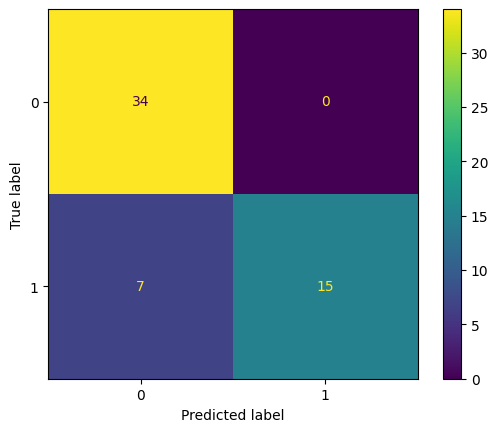

In [ ]:
ConfusionMatrixDisplay.from_estimator(rfc_best_model, X_test, y_test)

## Support Vector Machine (SVM)

In [ ]:
# Support Vector Machine pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])

# Parameters for SVM
svm_param_grid = {
    'svc__C': [0.005, 0.006, 0.007, 0.008, 0.009, 0.01],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto'],
    'svc__degree': [2, 3, 4],
    'svc__class_weight': ['balanced']
}

# Grid search with SVM
svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
svm_grid_search.fit(X_train, y_train)
svm_best_model = svm_grid_search.best_estimator_

# Predictions
y_test_pred = svm_best_model.predict(X_test)

# Accuracy scores
print(f"Train Accuracy: {svm_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best Parameters:", svm_grid_search.best_params_)

Train Accuracy: 0.9013452914798207
Test Accuracy: 0.8571428571428571
Best Parameters: {'svc__C': 0.007, 'svc__class_weight': 'balanced', 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}


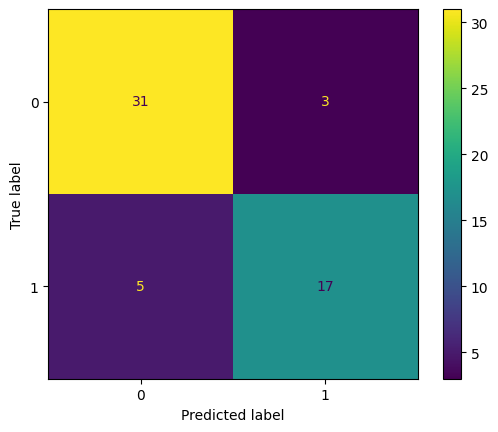

In [ ]:
ConfusionMatrixDisplay.from_estimator(svm_best_model, X_test, y_test)

## Logistic Regression

In [ ]:
# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(solver='saga', max_iter=5000, random_state=42))
])

# Logistic Pegression parameters
lr_param_grid = {
    'lr__C': [0.01, 0.03, 0.05, 0.07],
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__l1_ratio': [0.1, 0.5, 0.9],
    'lr__class_weight': ['balanced']
}

# Grid search with LR
lr_grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
lr_grid_search.fit(X_train, y_train)
lr_best_model = lr_grid_search.best_estimator_

# Predictions
y_test_pred = lr_best_model.predict(X_test)

# Accuracy scores
print(f"Train Accuracy: {lr_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best Parameters:", lr_grid_search.best_params_)

Train Accuracy: 0.9013452914798207
Test Accuracy: 0.8392857142857143
Best Parameters: {'lr__C': 0.03, 'lr__class_weight': 'balanced', 'lr__l1_ratio': 0.1, 'lr__penalty': 'l2'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


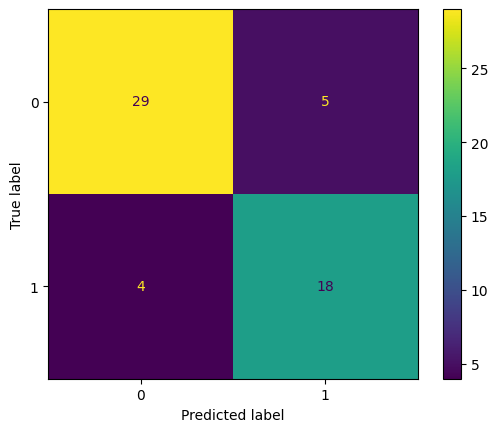

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr_best_model, X_test, y_test)

## Multi-layer perceptron

In [ ]:
# MLPClassifier pipeline
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=5,
        validation_fraction=0.1
    ))
])


# MLP parameter grid
mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50, 50), (75, 50), (75, 75), (100, 75), (125, 75)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.1, 0.5, 0.7, 0.8, 1, 2, 3, 5],
    'mlp__learning_rate_init': [0.005, 0.007, 0.01, 0.3, 0.05]
}

# Grid search for MLP
mlp_grid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=mlp_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='balanced_accuracy'
)
mlp_grid_search.fit(X_train, y_train)
mlp_best_model = mlp_grid_search.best_estimator_

# Predictions
y_test_pred = mlp_best_model.predict(X_test)

# Accuracy scores
print(f"Train Accuracy: {mlp_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best Parameters:", mlp_grid_search.best_params_)

Train Accuracy: 0.9417040358744395
Test Accuracy: 0.8392857142857143
Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.7, 'mlp__hidden_layer_sizes': (100, 75), 'mlp__learning_rate_init': 0.01}


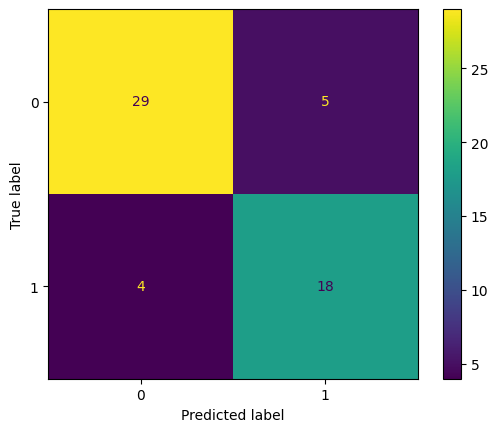

In [ ]:
ConfusionMatrixDisplay.from_estimator(mlp_best_model, X_test, y_test)

## Single Layer Perceptron

In [ ]:
# SLPClassifier pipeline
slp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('perceptron', Perceptron(tol=1e-3, random_state=0))
])


# Define parameter grid
slp_param_grid = {
    'perceptron__penalty': ['l2', 'l1', None],
    'perceptron__alpha': [5e-6, 7e-6, 8e-6, 9e-6, 1e-5, 3e-5, 5e-5],
    'perceptron__max_iter': [40, 50, 75, 100],
    'perceptron__eta0': [0.7, 0.8, 0.9, 1.0, 1.3, 1.5, 1.7],
    'perceptron__fit_intercept': [True, False]
}

# Create grid search
slp_grid_search = GridSearchCV(
    estimator=slp_pipeline,
    param_grid=slp_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit on training data
slp_grid_search.fit(X_train, y_train)
slp_best_model = slp_grid_search.best_estimator_

# Prediction
y_test_pred = slp_best_model.predict(X_test)

# Final accuracy scores
print(f"Train Accuracy: {slp_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best parameters: ", slp_grid_search.best_params_)

Train Accuracy: 0.8834080717488789
Test Accuracy: 0.8214285714285714
Best parameters:  {'perceptron__alpha': 3e-05, 'perceptron__eta0': 1.3, 'perceptron__fit_intercept': True, 'perceptron__max_iter': 40, 'perceptron__penalty': 'l2'}


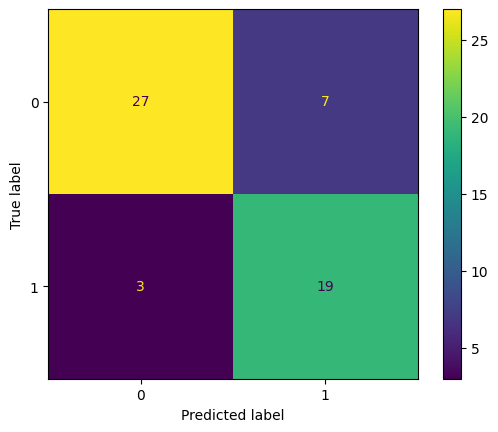

In [ ]:
ConfusionMatrixDisplay.from_estimator(slp_best_model, X_test, y_test)

## Ensemble Learning - Voting Classifier

In [ ]:
# Voting classifier
voting_model = VotingClassifier(
    estimators=[
        ('svm', svm_best_model),
        ('logreg', lr_best_model),
        ('mlp', mlp_best_model),
        ('slp', slp_best_model),
        ('rf', rfc_best_model)
    ],
    voting='hard'
)

# Fit to the model
voting_model.fit(X_train, y_train)

# Predict and evaluate
y_test_pred = voting_model.predict(X_test)
print(f"Ensemble Train Accuracy: {voting_model.score(X_train, y_train)}")
print(f"Ensemble Test Accuracy: {accuracy_score(y_test, y_test_pred)}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Ensemble Train Accuracy: 0.905829596412556
Ensemble Test Accuracy: 0.8392857142857143


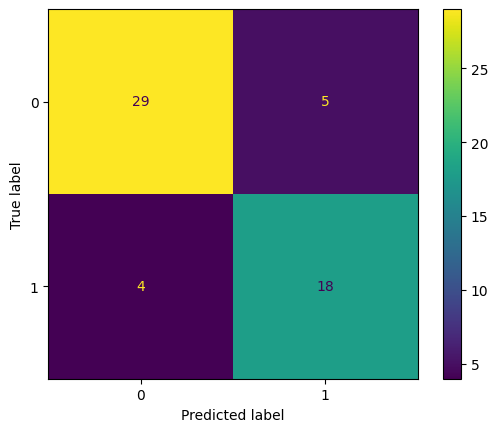

In [ ]:
ConfusionMatrixDisplay.from_estimator(voting_model, X_test, y_test)

## Ensemble Learning - Stacking Classifier

In [ ]:
# Stacking classifier
stacking_model = StackingClassifier(
    estimators=[
        ('svm', svm_best_model),
        ('logreg', lr_best_model),
        ('mlp', mlp_best_model),
        ('slp', slp_best_model),
        ('rf', rfc_best_model)
    ],
    final_estimator=LogisticRegression(), # Meta model
    cv=5,
    n_jobs=-1
)

stacking_param_grid = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
}
stacking_grid_search = GridSearchCV(stacking_model, stacking_param_grid, cv=5, n_jobs=-1)
stacking_grid_search.fit(X_train, y_train)
best_stacking_model = stacking_grid_search.best_estimator_

# Predict and evaluate
y_test_pred = best_stacking_model.predict(X_test)
print(f"Train Accuracy: {best_stacking_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")

Train Accuracy: 0.9327354260089686
Test Accuracy: 0.8571428571428571


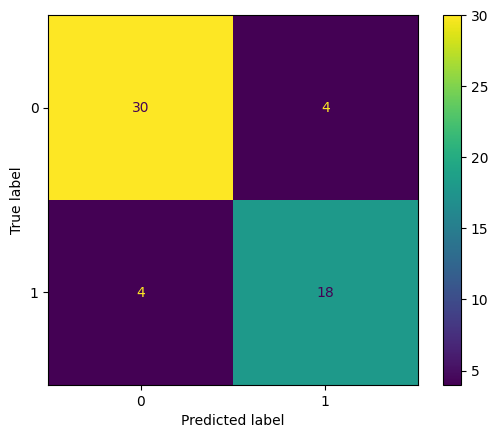

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_stacking_model, X_test, y_test)

## Feature Importance for Vital Status

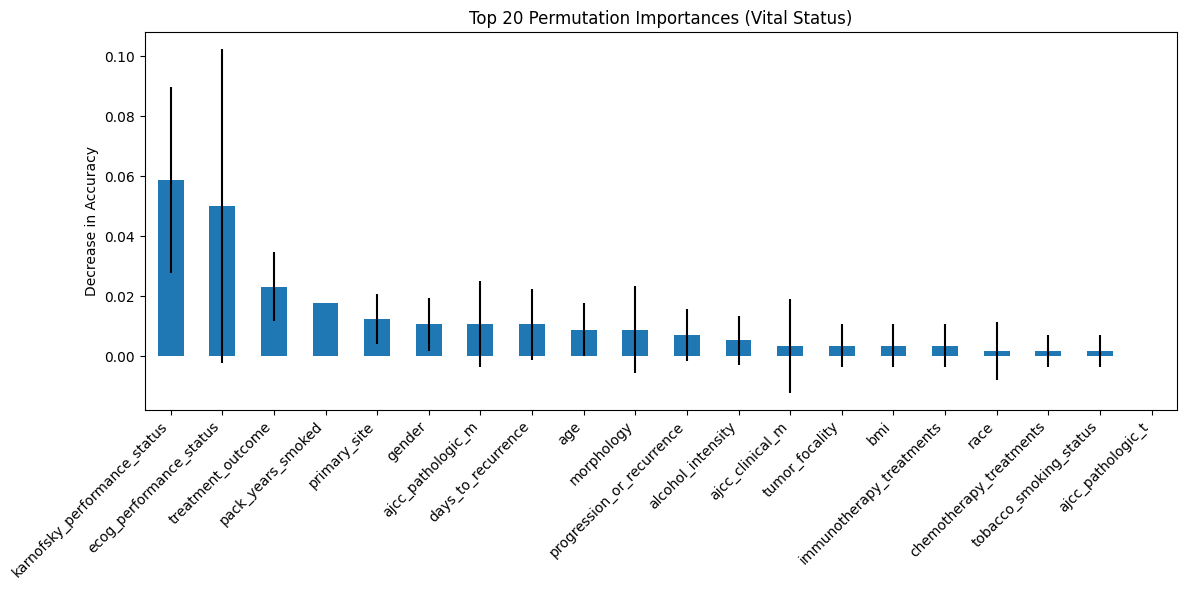

In [ ]:
# Use the best ensemble model for Vital, which is the voting classifier
result = permutation_importance(voting_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create series with importances
perm_importances = pd.Series(result.importances_mean, index=X.columns)
top_perm = perm_importances.sort_values(ascending=False).head(20)
top_perm_indices = [X.columns.get_loc(name) for name in top_perm.index]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
top_perm.plot.bar(yerr=result.importances_std[top_perm_indices], ax=ax)
ax.set_title("Top 20 Permutation Importances (Vital Status)")
ax.set_ylabel("Decrease in Accuracy")
plt.xticks(rotation=45, ha="right")
fig.tight_layout()
plt.show()


# Treatment Outcomes Models

In [ ]:
# feature columns
X = df.drop(['treatment_outcome'], axis = 1)
# label
y = df['treatment_outcome']

# split up data between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# show the dimensions of the training and testing data
print('X train: ', X_train.shape)
print('y train: ', len(y_train))
print('X test: ', X_test.shape)
print('y test: ', len(y_test))

X train:  (223, 35)
y train:  223
X test:  (56, 35)
y test:  56


## Random Forest Classifier

In [ ]:
# Parameter grid for Random Forest grid search
rfc_param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [2, 3, 4],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2']
}

# Grid search
rfc_grid_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42),
    param_grid = rfc_param_grid,
    cv = 5,
    n_jobs = -1,
    scoring = 'accuracy'
)
rfc_grid_search.fit(X_train, y_train)
rfc_best_model = rfc_grid_search.best_estimator_

y_test_pred = rfc_best_model.predict(X_test)

# Final accuracy scores
print(f"Train Accuracy: {rfc_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best parameters: ", rfc_grid_search.best_params_)

Train Accuracy: 0.9013452914798207
Test Accuracy: 0.8214285714285714
Best parameters:  {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}


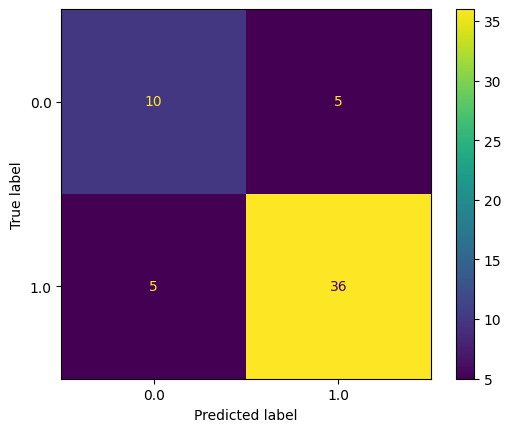

In [ ]:
ConfusionMatrixDisplay.from_estimator(rfc_best_model, X_test, y_test)

## Support Vector Machine

In [ ]:
# Support Vector Machine pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])

# Parameters for SVM
svm_param_grid = {
    'svc__C': [0.6, 0.61, 0.615, 0.62, 0.625, 0.63],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto'],
    'svc__degree': [2, 3, 4, 5],
    'svc__class_weight': ['balanced']
}

# Grid search with SVM
svm_grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
svm_grid_search.fit(X_train, y_train)
svm_best_model = svm_grid_search.best_estimator_

# Predictions
y_test_pred = svm_best_model.predict(X_test)

# Accuracy scores
print(f"Train Accuracy: {svm_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best Parameters:", svm_grid_search.best_params_)

Train Accuracy: 0.9372197309417041
Test Accuracy: 0.8214285714285714
Best Parameters: {'svc__C': 0.615, 'svc__class_weight': 'balanced', 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


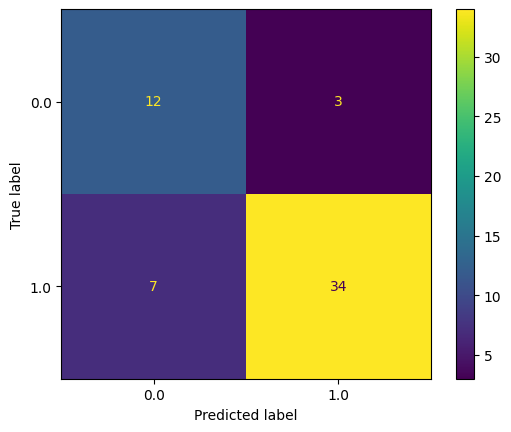

In [ ]:
ConfusionMatrixDisplay.from_estimator(svm_best_model, X_test, y_test)

## Logistic Regression

In [ ]:
# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(solver='saga', max_iter=5000, random_state=42))
])

# Logistic Pegression parameters
lr_param_grid = {
    'lr__C': [0.74, 0.76, 0.78, 0.79, 0.8, 0.81],
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__l1_ratio': [0.56, 0.565, 0.57, 0.575, 0.58],
    'lr__class_weight': ['balanced']
}

# Grid search with LR
lr_grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
lr_grid_search.fit(X_train, y_train)
lr_best_model = lr_grid_search.best_estimator_

# Predictions
y_test_pred = lr_best_model.predict(X_test)

# Accuracy scores
print(f"Train Accuracy: {lr_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best Parameters:", lr_grid_search.best_params_)

Train Accuracy: 0.905829596412556
Test Accuracy: 0.7142857142857143
Best Parameters: {'lr__C': 0.78, 'lr__class_weight': 'balanced', 'lr__l1_ratio': 0.57, 'lr__penalty': 'elasticnet'}


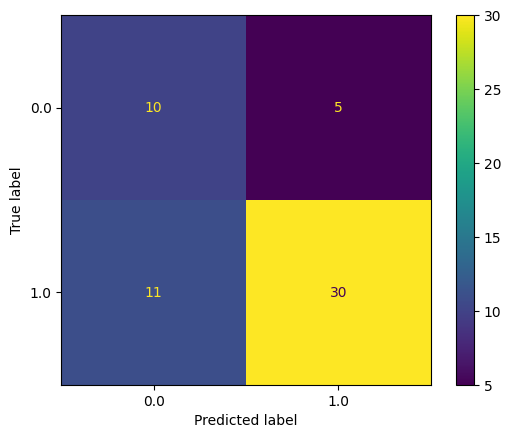

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr_best_model, X_test, y_test)

## Multi-layer Perceptron

In [ ]:
# MLPClassifier pipeline
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=3,
        validation_fraction=0.1
    ))
])


# MLP parameter grid
mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(45, 45), (25, 50), (50, 50), (55, 55), (100, 50), (50, 100), (100, 100)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [0.0005, 0.001, 0.005, 0.01]
}

# Grid search for MLP
mlp_grid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=mlp_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='balanced_accuracy'
)
mlp_grid_search.fit(X_train, y_train)
mlp_best_model = mlp_grid_search.best_estimator_

# Predictions
y_test_pred = mlp_best_model.predict(X_test)

# Accuracy scores
print(f"Train Accuracy: {mlp_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best Parameters:", mlp_grid_search.best_params_)

Train Accuracy: 0.9417040358744395
Test Accuracy: 0.8214285714285714
Best Parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 1e-07, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate_init': 0.01}


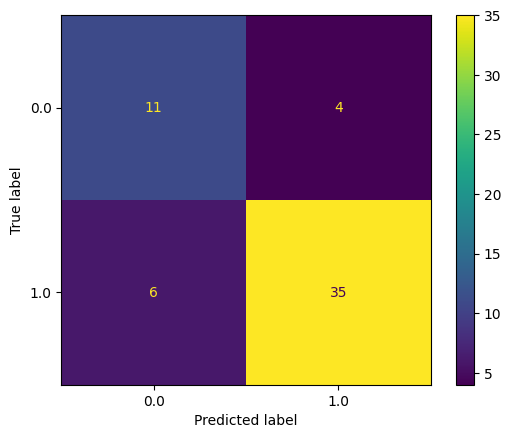

In [ ]:
ConfusionMatrixDisplay.from_estimator(mlp_best_model, X_test, y_test)

## Single Layer Perceptron

In [ ]:
# SLPClassifier pipeline
slp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('perceptron', Perceptron(tol=1e-3, random_state=0))
])


# Define parameter grid
slp_param_grid = {
    'perceptron__penalty': ['l2', 'l1', None],
    'perceptron__alpha': [8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 5e-5, 7e-5],
    'perceptron__max_iter': [25, 30, 40, 50],
    'perceptron__eta0': [0.7, 0.8, 0.9, 1.0, 1.3],
    'perceptron__fit_intercept': [True, False]
}

# Create grid search
slp_grid_search = GridSearchCV(
    #estimator=Perceptron(class_weight='balanced', tol=1e-3, random_state=0),
    estimator=slp_pipeline,
    param_grid=slp_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit on training data
slp_grid_search.fit(X_train, y_train)
slp_best_model = slp_grid_search.best_estimator_

# Prediction
y_test_pred = slp_best_model.predict(X_test)

# Final accuracy scores
print(f"Train Accuracy: {slp_best_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best parameters: ", slp_grid_search.best_params_)

Train Accuracy: 0.8968609865470852
Test Accuracy: 0.75
Best parameters:  {'perceptron__alpha': 2e-05, 'perceptron__eta0': 0.7, 'perceptron__fit_intercept': True, 'perceptron__max_iter': 25, 'perceptron__penalty': 'l1'}


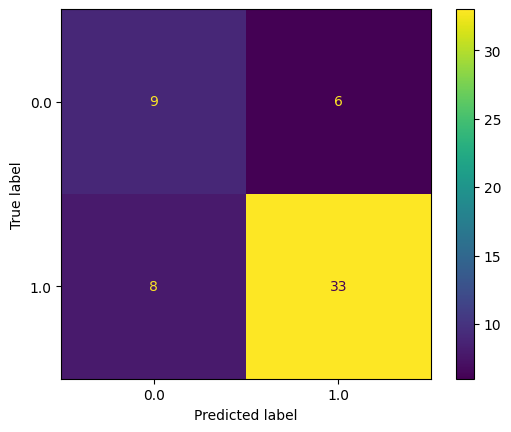

In [ ]:
ConfusionMatrixDisplay.from_estimator(slp_best_model, X_test, y_test)

## Ensemble Learning - Voting Classifier

In [ ]:
# Voting classifier
voting_model = VotingClassifier(
    estimators=[
        ('svm', svm_best_model),
        ('logreg', lr_best_model),
        ('mlp', mlp_best_model),
        ('slp', slp_best_model),
        ('rf', rfc_best_model)
    ],
    voting='hard'
)

# Fit to the model
voting_model.fit(X_train, y_train)

# Predict and evaluate
y_test_pred = voting_model.predict(X_test)
print(f"Ensemble Train Accuracy: {voting_model.score(X_train, y_train)}")
print(f"Ensemble Test Accuracy: {accuracy_score(y_test, y_test_pred)}")

Ensemble Train Accuracy: 0.9461883408071748
Ensemble Test Accuracy: 0.8214285714285714


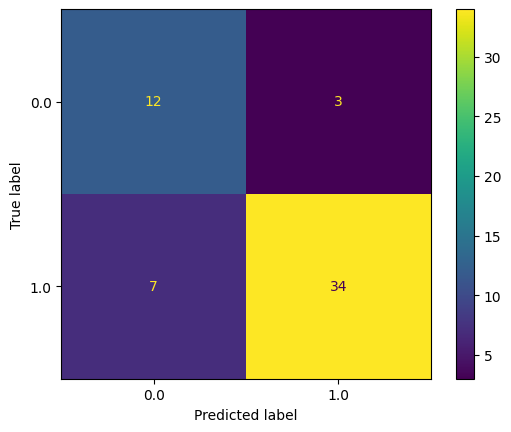

In [ ]:
ConfusionMatrixDisplay.from_estimator(voting_model, X_test, y_test)

## Ensemble Learning - Stacking Classifier

In [ ]:
# Stacking classifier
stacking_model = StackingClassifier(
    estimators=[
        ('svm', svm_best_model),
        ('logreg', lr_best_model),
        ('mlp', mlp_best_model),
        ('slp', slp_best_model),
        ('rf', rfc_best_model)
    ],
    final_estimator=LogisticRegression(), # Meta model
    cv=5,
    n_jobs=-1
)

stacking_param_grid = {
    'final_estimator__C': [0.001, 0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2']
    #'final_estimator__penalty': ['l1', 'l2', 'elasticnet'],
    #'final_estimator__l1_ratio': [0.56, 0.565, 0.57, 0.575, 0.58],
    #'final_estimator__class_weight': ['balanced']
}


stacking_grid_search = GridSearchCV(stacking_model, stacking_param_grid, cv=5, n_jobs=-1)
stacking_grid_search.fit(X_train, y_train)
best_stacking_model = stacking_grid_search.best_estimator_

# Predict and evaluate
y_test_pred = best_stacking_model.predict(X_test)
print(f"Train Accuracy: {best_stacking_model.score(X_train, y_train)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print("Best parameters: ", stacking_grid_search.best_params_)

Train Accuracy: 0.9461883408071748
Test Accuracy: 0.8392857142857143
Best parameters:  {'final_estimator__C': 1, 'final_estimator__penalty': 'l2'}


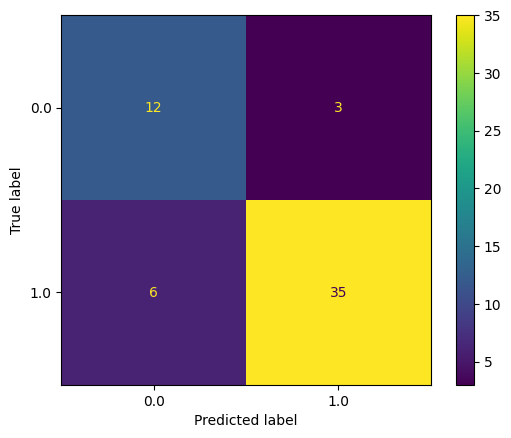

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_stacking_model, X_test, y_test)

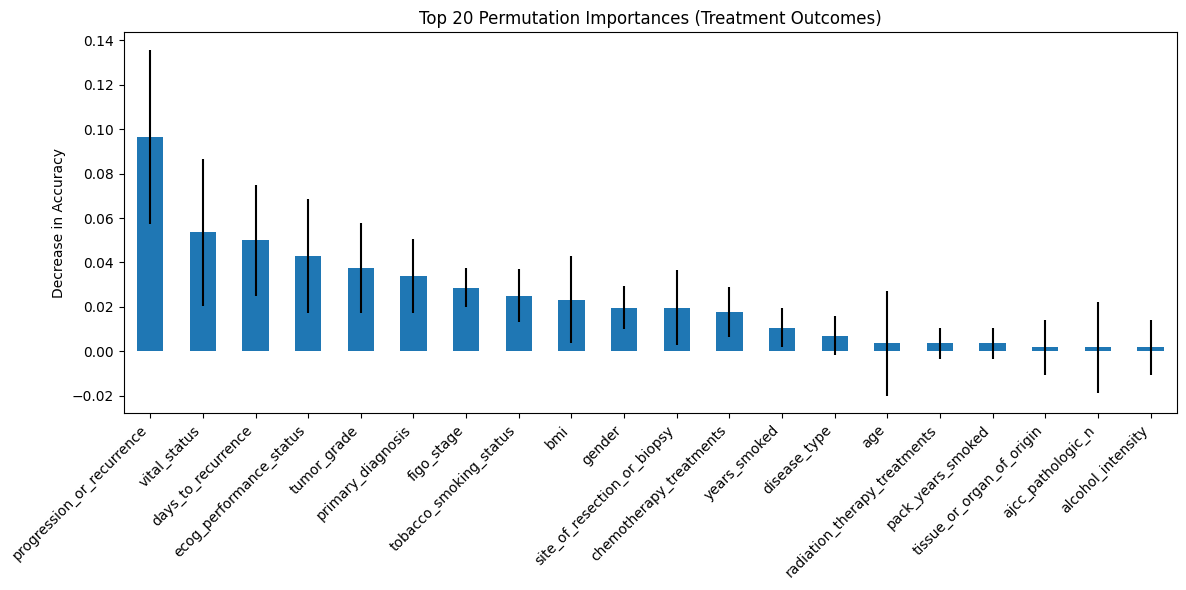

In [ ]:
# Use the best ensemble model for treatment outcomes, which is the stacking classifier
result = permutation_importance(best_stacking_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Create series with importances
perm_importances = pd.Series(result.importances_mean, index=X.columns)
top_perm = perm_importances.sort_values(ascending=False).head(20)
top_perm_indices = [X.columns.get_loc(name) for name in top_perm.index]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
top_perm.plot.bar(yerr=result.importances_std[top_perm_indices], ax=ax)
ax.set_title("Top 20 Permutation Importances (Treatment Outcomes)")
ax.set_ylabel("Decrease in Accuracy")
plt.xticks(rotation=45, ha="right")
fig.tight_layout()
plt.show()
